# AlexNet for Image classification.

A simple implementation of [AlexNet](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) for playing around with.
Training it on CIFAR-10 as it's a standard dataset that is largely solved.

This (obivously) is no great acheivement in and of itself, but is intended as a spring board, especially for me to understand the computer science version of a convolution.

In [1]:
import torch
import torchvision
import torchvision.transforms as tfms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

Running on cuda


We set the batch size, this is proportional to the memory available on your device.
The author used the value below, but feel free to experiment with it!

Use a value somewhere between 2 and 32 according to [this paper](https://arxiv.org/abs/1804.07612).

In [2]:
bs = 32

## CIFAR-10

CIFAR-10 is a labelled subset of the [80 million tiny images dataset](https://en.wikipedia.org/wiki/80_Million_Tiny_Images), with 6000 32x32 colour images in 10 classes, with 6000 images per class.
There are 50,000 training images and 10,000 test images.

The dataset can be found [here](https://www.cs.toronto.edu/~kriz/cifar.html).

In [3]:
mean = (0.5, 0.5, 0.5)  # (r, g, b)
std =  (0.5, 0.5, 0.5)  # (r, g, b)

transforms = tfms.Compose([
    tfms.ToTensor(),
    tfms.Normalize(mean, std)
])

In [4]:
dataset = torchvision.datasets.CIFAR10('./data', train=True, download=True , transform=transforms)
testset = torchvision.datasets.CIFAR10('./data', train=False, download=True , transform=transforms)

trainset, valset = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.9), int(len(dataset) * 0.1)])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True)
valloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### Dataset Exploration

We need to have a look at and truly understand the data to be able to classify it

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img.numpy() / 2 + 0.5  # Undo normalisation

    # Matplotlib expects H * W * C, PyTorch is C * H * W
    # So transpose and swizzle
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

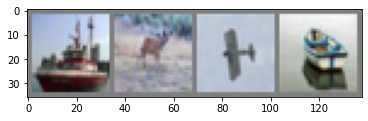

ship, deer, plane, ship


In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(", ".join(classes[labels[i]] for i in range(len(labels))))

## Model

### Convolutional Neural Networks (CNNs)

The convolution of two functions $f$ and $g$ is defined as:

$$
(f * g)(t) = \int_{-\infty}^{\infty} f(\tau) g(t - \tau) \text{d} \tau
$$

This doesn't explain a whole lot,

PyTorch (for the sake of fewer operations) decided to implement this as a different

$$
(f \otimes g)(t) = \int_{-\infty}^{\infty} f(\tau) g(t + \tau) \text{d} \tau
$$

This is associative, distributive, but isn't commutative! 

Under the usual well-behaved conditions, a convolution is a multilplication in Fourier space, i.e. 

$$
f * g = \mathcal{F}^{-1} \left\{
    \mathcal{F}\left( f \right) \cdot \mathcal{F}\left(g \right)
\right\},\\

f \otimes g = \mathcal{F}^{-1} \left\{
    \overline{ \mathcal{F}\left( f \right) } \cdot \mathcal{F}\left(g \right)
\right\}.
$$

This is ideal if you are wanting to calculate a bigger convolution, i.e. the kernel size is on the order of the signal.

### AlexNet

Our model is a typical [AlexNet](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) and is taken from the paper [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf).

It looks like this:
![]()

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(torch.nn.Module):
    def __init__(self, D_in=32, D_out=10):
        """
        D_in:
            Width of Image to apply network to
        D_out:
            Number of classes to output
        """
        super().__init__()
        self.conv1 = nn.Conv2d(3,   96,  5, padding=2)
        self.conv2 = nn.Conv2d(96,  256, 3, padding=1)
        self.conv3 = nn.Conv2d(256, 384, 2)
        self.conv4 = nn.Conv2d(384, 384, 2)
        self.conv5 = nn.Conv2d(384, 256, 2)

        # TODO: Experiment with cool pooling types
        self.pool = nn.MaxPool2d(2, 2)
        # self.pool = nn.AvgPool2d(2, 2)
        # self.pool = nn.AdaptiveMaxPool2d(2, 2)
        # self.pool = nn.AdaptiveAvgPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, D_out)

    def forward(self, x):
        # Top 5 Conv layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))

        # Flatten
        x = torch.flatten(x, start_dim=1)

        # FC endpoint
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
model = AlexNet().to(device)

## Optimizer

Define a loss function and optimizer

In [11]:
loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1.e-3, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)

### Fit 1cycle

In [12]:
num_epochs = 10

In [13]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=1.e-3, steps_per_epoch=len(trainloader), epochs=num_epochs)

## Training

In [14]:
for epoch in range(num_epochs):

    running_loss = 0.

    for i, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass: Compute predicted y by passing x to the model
        outputs = model(inputs)

        # Compute and print loss
        loss = loss_fn(outputs, targets)

        # Perform a backward pass, and update the weights.
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print statistics
        running_loss += loss.item()
        print_every = 1_000
        if i % print_every == print_every - 1:
            print(f"Epoch {epoch + 1}{i + 1:6}, train loss: {running_loss / (print_every * bs)}")  # loss since previous print out
            running_loss = 0.
    
    # At the end of the epoch, show the validation loss
    with torch.no_grad():
        validation_loss = 0.
        for i, (inputs, targets) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            validation_loss += loss_fn(outputs, targets).item()
        print(f"Epoch {epoch + 1}, validation loss: {validation_loss / (bs * len(valloader))}")
print("Finished Training")

Epoch 1  1000, train loss: 0.5334246696531773
Epoch 1  2000, train loss: 0.4895823401212692
Epoch 1  3000, train loss: 0.4711957250088453
Epoch 1  4000, train loss: 0.4456832774877548
Epoch 1  5000, train loss: 0.42607590663433076
Epoch 1  6000, train loss: 0.4094716094657779
Epoch 1  7000, train loss: 0.40159047047048807
Epoch 1  8000, train loss: 0.39273838011361656
Epoch 1  9000, train loss: 0.38973890237510206
Epoch 1 10000, train loss: 0.38575230657309295
Epoch 1 11000, train loss: 0.3675470471903682
Epoch 1, validation loss: 0.35844322899878023
Epoch 2  1000, train loss: 0.3595952275320888
Epoch 2  2000, train loss: 0.35345550755038857
Epoch 2  3000, train loss: 0.34418671135045587
Epoch 2  4000, train loss: 0.3435445102863014
Epoch 2  5000, train loss: 0.34680610855296257
Epoch 2  6000, train loss: 0.34109994874149563
Epoch 2  7000, train loss: 0.3260461309701204
Epoch 2  8000, train loss: 0.3290744497533888
Epoch 2  9000, train loss: 0.3190651085237041
Epoch 2 10000, train loss

In [15]:
path = "./alexnet_cifar10-one-cycle.pth"
torch.save(model.state_dict(), path)

## Evaluation

In [16]:
model.eval()

AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(256, 384, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

### Confusion Matrix

This is a great little idea that visually represents how consfused the model is.
This shows visually, what the model predicted for a given number of inputs with its top one.

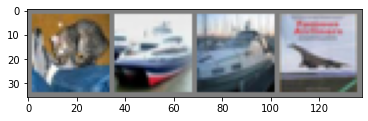

Ground truth: cat, ship, ship, plane
Model: cat, ship, ship, plane


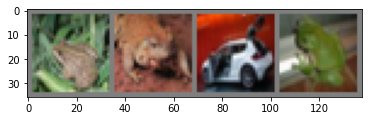

Ground truth: frog, frog, car, frog
Model: frog, frog, truck, frog


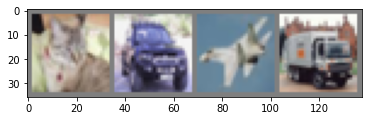

Ground truth: cat, car, plane, truck
Model: cat, car, horse, truck


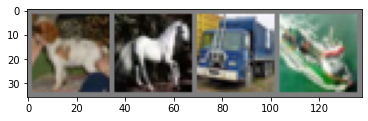

Ground truth: dog, horse, truck, ship
Model: deer, horse, truck, ship


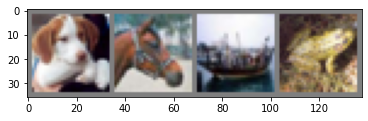

Ground truth: dog, horse, ship, frog
Model: dog, horse, ship, frog


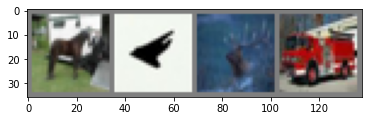

Ground truth: horse, plane, deer, truck
Model: horse, bird, deer, truck


In [17]:
for batch_idx, (inputs, targets) in enumerate(testloader):
    inputs, targets = inputs.to(device), targets.to(device)

    imshow(torchvision.utils.make_grid(inputs).cpu())

    outputs = model(inputs)
    top_one = torch.argmax(outputs, dim=-1)

    print("Ground truth:", ", ".join(classes[targets[i]] for i in range(len(targets))))
    print("Model:", ", ".join(classes[top_one[i]] for i in range(len(top_one))))

    if batch_idx >= 5:
        break

In [18]:
cm = torch.zeros(len(classes), len(classes))

for i, (inputs, targets) in enumerate(testloader):
    inputs, targets = inputs.to(device), targets.to(device)
    
    targets_pred = model(inputs)
    top_one = torch.argmax(targets_pred, dim=-1) # Take the estimate of the top-one

    for j in range(bs):
        cm[top_one[j], targets[j]] += 1.

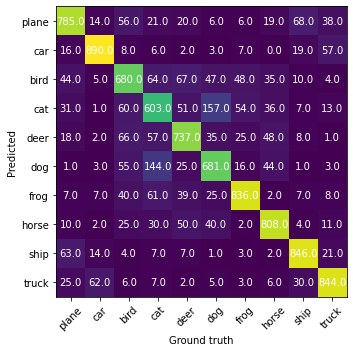

In [19]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, cmap="viridis")
    plt.xlabel("Ground truth")
    plt.ylabel("Predicted")
    plt.xticks(range(len(classes)), classes, rotation=45)
    plt.yticks(range(len(classes)), classes)

    # Add text
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.gca().text(j, i, f"{cm[i, j]:.1f}", ha="center", va="center", color="w")

    plt.tight_layout()
    plt.show()
plot_confusion_matrix(cm, classes)

In [20]:
accuracy = torch.sum(torch.diag(cm)) / torch.sum(torch.sum(cm))
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 77.10%
